In [131]:
# !pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression

In [132]:
# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets
df = pd.concat([X,y], axis=1)
df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [133]:
# wine_quality.metadata, wine_quality.variables, X.describe()

In [134]:
print(f'Número de observações (N): {X.shape[0]}.')
print(f'Número de preditores (D): {X.shape[1]}.')
print('Variável alvo (Y):', wine_quality.metadata['target_col'])

Número de observações (N): 6497.
Número de preditores (D): 11.
Variável alvo (Y): ['quality']


# Skewness visualization

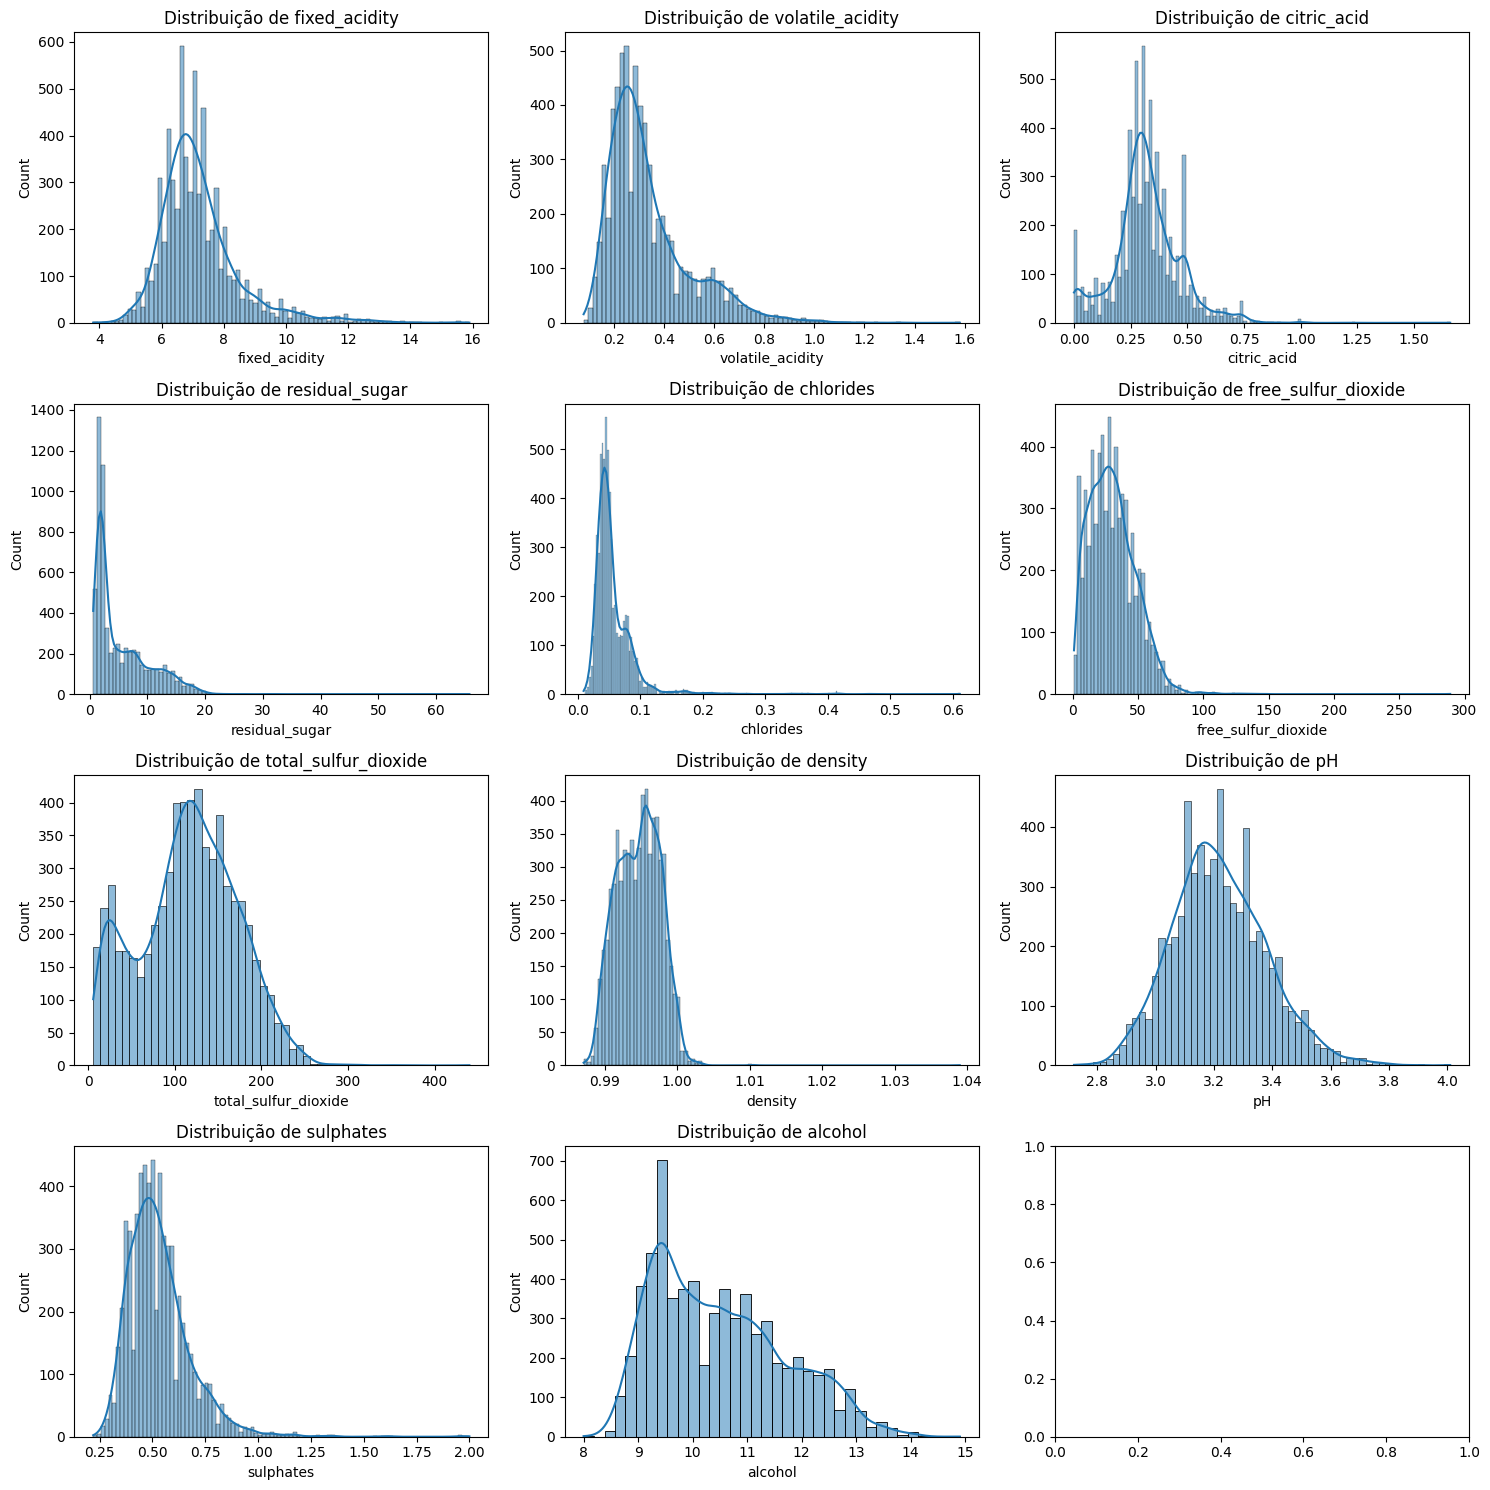

In [135]:
num_cols = [col for col in X.columns]
fig, axes = plt.subplots(4, 3, figsize=(15,15))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(X[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribuição de {col}')
plt.tight_layout()

In [136]:
skew_values = X[num_cols].apply(lambda x: skew(x.dropna()))
print(skew_values)

fixed_acidity           1.722892
volatile_acidity        1.494751
citric_acid             0.471622
residual_sugar          1.435073
chlorides               5.398581
free_sulfur_dioxide     1.219784
total_sulfur_dioxide   -0.001177
density                 0.503485
pH                      0.386749
sulphates               1.796855
alcohol                 0.565587
dtype: float64


# Remove skewness with Yeo and Johnson transformation

In [137]:
features_with_zeros = [column for column in X.columns if (X[column] == 0).any()]

X_transformed = X.copy()

for col in X.columns:
    if abs(skew_values[col])>0.5:
        X_transformed[col] = np.log1p(X_transformed[col]) if col in features_with_zeros else np.log(X_transformed[col])

In [138]:
skew_values_transformed = X_transformed[num_cols].apply(lambda x: skew(x.dropna()))
print(skew_values_transformed)

fixed_acidity           0.888932
volatile_acidity        0.327723
citric_acid             0.471622
residual_sugar          0.240636
chlorides               0.876270
free_sulfur_dioxide    -0.834005
total_sulfur_dioxide   -0.001177
density                 0.467260
pH                      0.386749
sulphates               0.404899
alcohol                 0.381772
dtype: float64


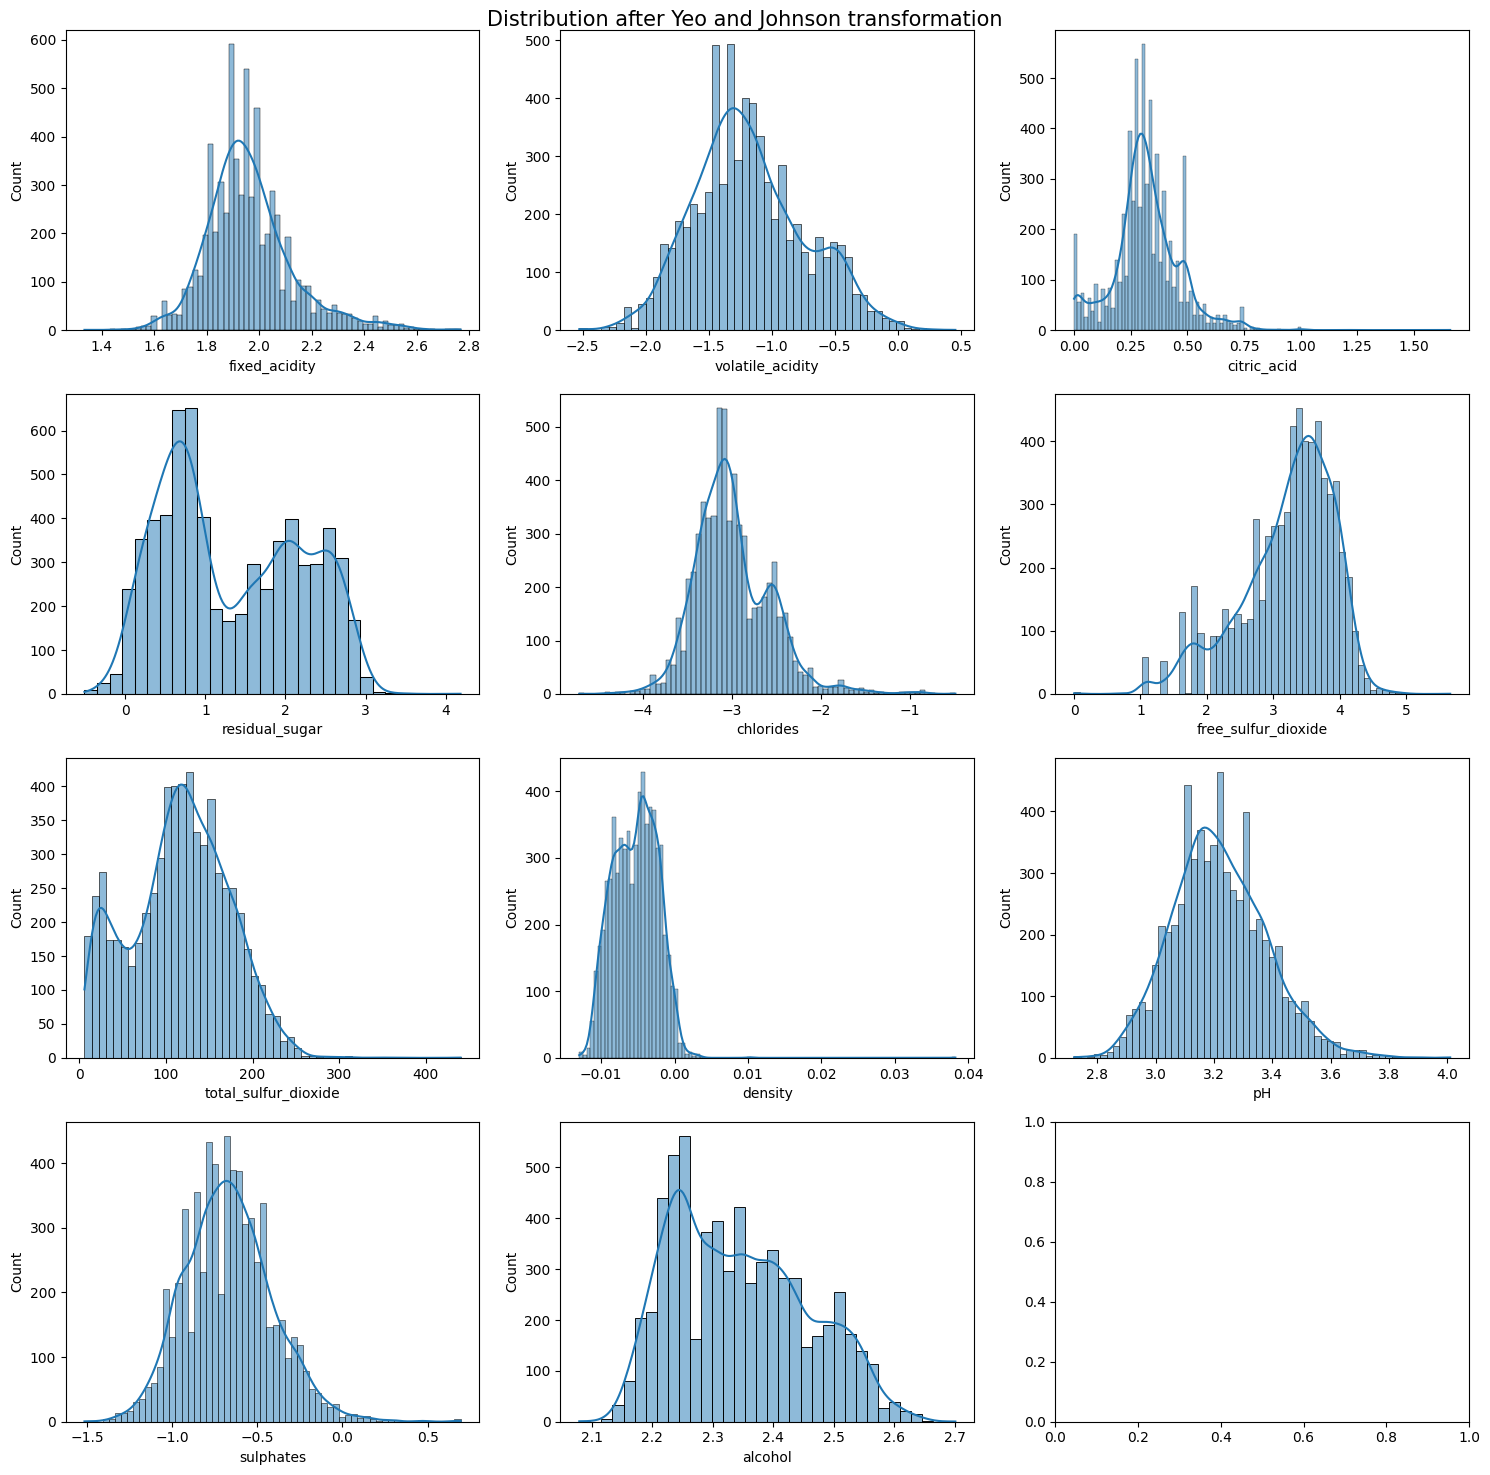

In [139]:
num_cols_transformed = [col for col in X_transformed.columns]

fig, axes = plt.subplots(4, 3, figsize=(15,15))
axes = axes.flatten()

for i, col in enumerate(num_cols_transformed):
    sns.histplot(X_transformed[col], kde=True, ax=axes[i])
    # axes[i].set_title(f'Distribuição de {col}')
fig.suptitle("Distribution after Yeo and Johnson transformation", fontsize=15)
fig.tight_layout()

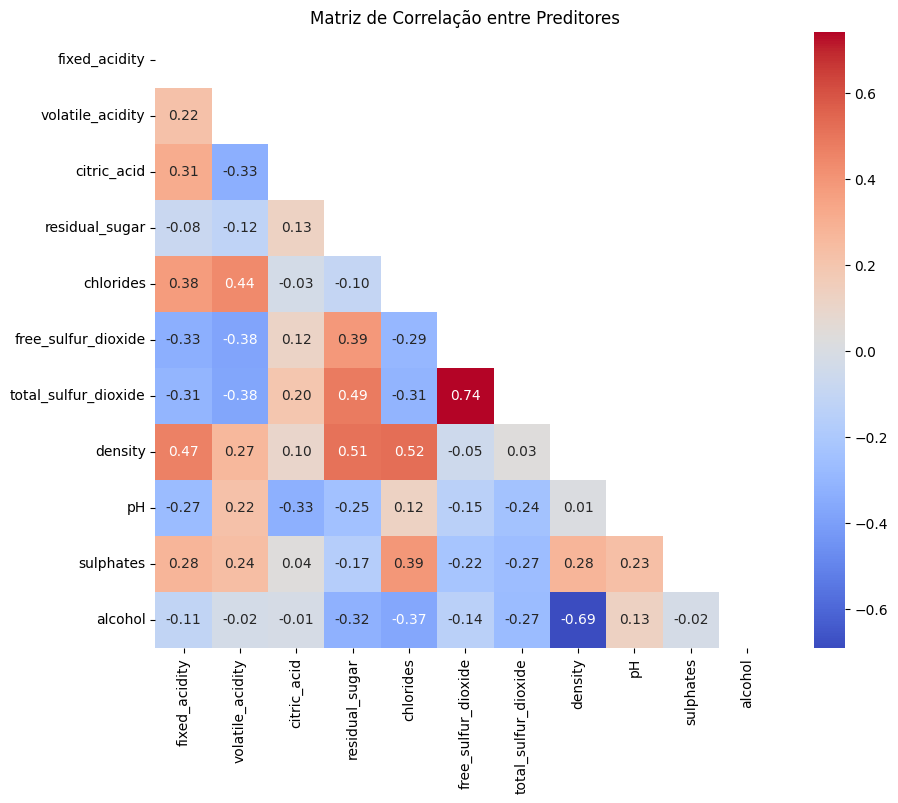

In [140]:
# Se quisermos a matriz de correlação depois de transformada
corr_matrix = X_transformed[num_cols_transformed].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt='.2f',
            mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title('Matriz de Correlação entre Preditores')
plt.show()

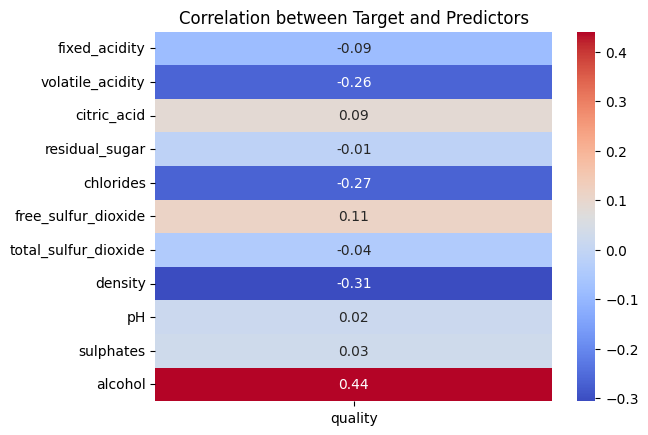

In [245]:
corr_matrix = pd.concat([X_transformed, y], axis=1)
sns.heatmap(corr_matrix.corr()[['quality']].drop(['quality']),
            annot=True,
            cmap='coolwarm',
            fmt='.2f'
)
plt.title('Correlation between Target and Predictors')
plt.show()

In [142]:
X_transformed

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,2.001480,-0.356675,0.00,0.641854,-2.577022,2.397895,34.0,-0.002202,3.51,-0.579818,2.240710
1,2.054124,-0.127833,0.00,0.955511,-2.322788,3.218876,67.0,-0.003205,3.20,-0.385662,2.282382
2,2.054124,-0.274437,0.04,0.832909,-2.385967,2.708050,54.0,-0.003005,3.26,-0.430783,2.282382
3,2.415914,-1.272966,0.56,0.641854,-2.590267,2.833213,60.0,-0.002002,3.16,-0.544727,2.282382
4,2.001480,-0.356675,0.00,0.641854,-2.577022,2.397895,34.0,-0.002202,3.51,-0.579818,2.240710
...,...,...,...,...,...,...,...,...,...,...,...
6492,1.824549,-1.560648,0.29,0.470004,-3.244194,3.178054,92.0,-0.008899,3.27,-0.693147,2.415914
6493,1.887070,-1.139434,0.36,2.079442,-3.057608,4.043051,168.0,-0.005113,3.15,-0.776529,2.261763
6494,1.871802,-1.427116,0.19,0.182322,-3.194183,3.401197,111.0,-0.007488,2.99,-0.776529,2.240710
6495,1.704748,-1.237874,0.30,0.095310,-3.816713,2.995732,110.0,-0.011374,3.34,-0.967584,2.549445


In [143]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y,
    test_size=0.33
)

print(f'Tamanho do conjunto de treino: {X_train.shape[0]} observações.')
print(f'Tamanho do conjunto de teste: {y_test.shape[0]} observações.')

Tamanho do conjunto de treino: 4352 observações.
Tamanho do conjunto de teste: 2145 observações.


In [144]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.min(), X_train_scaled.max(), X_test_scaled.min(), X_test_scaled.max()

(np.float64(-4.619833886943173),
 np.float64(5.7686137297945494),
 np.float64(-4.619833886943173),
 np.float64(14.683328148323119))

In [145]:
scaler.scale_, scaler.mean_

(array([1.64859686e-01, 4.36171559e-01, 1.45256572e-01, 8.61834800e-01,
        4.32689374e-01, 6.97270132e-01, 5.66114547e+01, 2.96493997e-03,
        1.59607581e-01, 2.55848293e-01, 1.11430953e-01]),
 array([ 1.96420613e+00, -1.17970960e+00,  3.20261949e-01,  1.33158318e+00,
        -2.98867618e+00,  3.22127218e+00,  1.16024816e+02, -5.29572384e-03,
         3.21673024e+00, -6.66575852e-01,  2.34308950e+00]))

In [146]:
X_test_scaled.mean(), X_train_scaled.mean()

(np.float64(-0.010266857049854304), np.float64(2.3963303118413303e-16))

In [147]:
X_train_scaled1 = np.c_[np.ones_like(X_train_scaled[:, 0]), X_train_scaled]
X_test_scaled1 = np.c_[np.ones_like(X_test_scaled[:, 0]), X_test_scaled]

In [148]:
X_train_scaled.shape, X_test_scaled.shape, X_train_scaled1.shape, X_test_scaled1.shape

((4352, 11), (2145, 11), (4352, 12), (2145, 12))

# CUSTOM OLS

$$
\boldsymbol{\beta} = \left( X^\top X \right)^{-1} X^\top \mathbf{y}
$$

In [149]:
beta = np.linalg.inv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T @ y_train
beta

,quality
0,0.071728
1,-0.220441
2,0.000628
3,0.187793
4,-0.021441
5,0.181424
6,-0.197585
7,-0.118710
8,0.039033
9,0.112104


In [150]:
def custom_OLS(X_train, X_test, y_train, y_test):

  beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

  y_train_pred = X_train @ beta
  y_test_pred = X_test @ beta

  #Train Error
  RSS_train = np.sum((np.array(y_train_pred) - np.array(y_train))**2)
  MSE_train = RSS_train/y_train.shape[0]
  R2_train = 1 - np.sum((np.array(y_train) - np.array(y_train_pred)) ** 2) / np.sum((np.array(y_train) - np.array(y_train).mean()) ** 2)

  print(f'RSS_train = {RSS_train}')
  print(f'MSE_train = {MSE_train}')
  print(f'R2_train = {R2_train}\n\n')

  #Test Error
  RSS = np.sum((np.array(y_test_pred) - np.array(y_test))**2)
  MSE = RSS/y_test.shape[0]
  R2 = 1 - np.sum((np.array(y_test) - np.array(y_test_pred)) ** 2) / np.sum((np.array(y_test) - np.array(y_test).mean()) ** 2)

  print(f'RSS_test = {RSS:.3f}')
  print(f'MSE_test = {MSE:.3f}')
  print(f'R2_test = {R2:.3f}')

custom_OLS(X_train_scaled1, X_test_scaled1, y_train, y_test)


RSS_train = 2364.960033399524
MSE_train = 0.5434191253215818
R2_train = 0.29377341962453296


RSS_test = 1085.671
MSE_test = 0.506
R2_test = 0.323


In [151]:
model = LinearRegression().fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'MSE = {mse:.3f}')
print(f'R2 = {r2:.3f}')

MSE = 0.506
R2 = 0.323


# KFOLD CUSTOM

In [152]:
def custom_Kfold(k, X, Y, random_seed=42):

    X = np.array(X)
    Y = np.array(Y)

    n = len(X)
    
    np.random.seed(random_seed)
    indexes = np.random.permutation(n)
    X = X[indexes]
    Y = Y[indexes]

    fold_size = n//k
    folds = []

    for i in range(k):
        test_start = i * fold_size
        test_end = test_start + fold_size if i < k - 1 else n-2

        X_test = X[test_start:test_end]
        Y_test = Y[test_start:test_end]

        X_train = np.concatenate((X[:test_start], X[test_end:]), axis=0)
        Y_train = np.concatenate((Y[:test_start], Y[test_end:]), axis=0)

        folds.append([X_train, X_test, Y_train, Y_test])

    return folds

PARA OLS
$$
\boldsymbol{\beta} = \left( X^\top X  \right )^{-1} X^\top \mathbf{y}
$$

PARA RIDGE
$$
\boldsymbol{\beta} = \left( X^\top X - \boldsymbol{\lambda}I \right )^{-1} X^\top \mathbf{y}
$$



In [153]:
def KfoldCV(X_train, X_test, y_train, y_test, mse_train_list, r2_train_list, mse_test_list, r2_test_list, mode, regression, penalty):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        if mode == 'custom':
            X_train_scaled = np.c_[np.ones_like(X_train_scaled[:, 0]), X_train_scaled]
            X_test_scaled = np.c_[np.ones_like(X_test_scaled[:, 0]), X_test_scaled]
            beta = np.linalg.inv((X_train_scaled.T @ X_train_scaled + (penalty * np.identity(X_train_scaled.shape[1])))) @ X_train_scaled.T @ y_train

            y_train_pred = X_train_scaled @ beta
            y_test_pred = X_test_scaled @ beta

            #Train Error
            RSS_train = np.sum((np.array(y_train_pred) - np.array(y_train))**2)
            MSE_train = RSS_train/y_train.shape[0]
            R2_train = 1 - np.sum((np.array(y_train) - np.array(y_train_pred)) ** 2) / np.sum((np.array(y_train) - np.array(y_train).mean()) ** 2)

            mse_train_list.append(MSE_train)
            r2_train_list.append(R2_train)

            #Test Error
            RSS = np.sum((np.array(y_test_pred) - np.array(y_test))**2)
            MSE = RSS/y_test.shape[0]
            R2 = 1 - np.sum((np.array(y_test) - np.array(y_test_pred)) ** 2) / np.sum((np.array(y_test) - np.array(y_test).mean()) ** 2)

            mse_test_list.append(MSE)
            r2_test_list.append(R2)

            
        elif mode == 'built-in':
            if regression == 'OLS':
                model = LinearRegression().fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)

                r2 = r2_score(y_test, y_pred)
                mse = mean_squared_error(y_test, y_pred)
                # print(f'MSE = {mse:.3f}')
                # print(f'R2 = {r2:.3f}')
                
            elif regression == 'RIDGE':
                ridge = Ridge(alpha=penalty)
                ridge.fit(X_train_scaled, y_train)
                y_pred = ridge.predict(X_test_scaled)

                r2 = r2_score(y_test, y_pred)
                mse = mean_squared_error(y_test, y_pred)
                # print(f'MSE = {mse:.3f}')
                # print(f'R2 = {r2:.3f}')
            mse_test_list.append(mse)
            r2_test_list.append(r2)
        # return mse_test_list, 

def Kfold_CV(k, X, Y, print_kfold=False, regression = 'OLS', mode='custom', kf_mode='custom', penalty=0, lambdas = np.arange(1, 1001, 1)):

    mse_train_list = []
    r2_train_list = []
    mse_test_list = []
    r2_test_list = []
    
    if kf_mode == 'custom':
        folds = custom_Kfold(k, X, Y)
        for i, (X_train, X_test, y_train, y_test) in enumerate(folds):
            KfoldCV(X_train, X_test, y_train, y_test, mse_train_list, r2_train_list, mse_test_list, r2_test_list, mode, regression, penalty)

    elif kf_mode == 'built-in':

        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        
        mse_test_list = []
        r2_test_list = []

        for i, (train_index, test_index) in enumerate(kf.split(X)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
            KfoldCV(X_train, X_test, y_train, y_test, mse_train_list, r2_train_list, mse_test_list, r2_test_list, mode, regression, penalty)

    if print_kfold:
        df_results = pd.DataFrame({
        #     'MSE_train': mse_train_list,
        #     'R2_train': r2_train_list,
            'MSE_test': mse_test_list,
            'R2_test': r2_test_list
        })

        display(df_results.style.format({
        #     'MSE_train': '{:.3f}',
        #     'R2_train': '{:.3f}',
            'MSE_test': '{:.3f}',
            'R2_test': '{:.3f}'
        }))

    return np.min(mse_test_list), r2_test_list[np.argmin(mse_test_list)]



Running OLS configurations

Configuration: k=5, mode=custom


,MSE_test,R2_test
0,0.531,0.281
1,0.536,0.297
2,0.524,0.320
3,0.540,0.308
4,0.535,0.297


Results: MSE=0.524, R2=0.320


Configuration: k=5, mode=custom


,MSE_test,R2_test
0,0.532,0.280
1,0.535,0.299
2,0.525,0.318
3,0.541,0.308
4,0.533,0.298


Results: MSE=0.525, R2=0.318


Configuration: k=5, mode=built-in


,MSE_test,R2_test
0,0.531,0.281
1,0.536,0.297
2,0.524,0.320
3,0.540,0.308
4,0.535,0.297


Results: MSE=0.524, R2=0.320


Configuration: k=5, mode=built-in


,MSE_test,R2_test
0,0.532,0.280
1,0.535,0.299
2,0.525,0.318
3,0.541,0.308
4,0.533,0.298


Results: MSE=0.525, R2=0.318


Configuration: k=10, mode=custom


,MSE_test,R2_test
0,0.482,0.330
1,0.581,0.234
2,0.494,0.307
3,0.575,0.290
4,0.529,0.335
5,0.525,0.298
6,0.570,0.308
7,0.509,0.309
8,0.604,0.251
9,0.460,0.354


Results: MSE=0.460, R2=0.354


Configuration: k=10, mode=custom


,MSE_test,R2_test
0,0.481,0.330
1,0.584,0.231
2,0.490,0.309
3,0.578,0.289
4,0.526,0.343
5,0.524,0.290
6,0.576,0.306
7,0.504,0.312
8,0.602,0.255
9,0.461,0.351


Results: MSE=0.461, R2=0.351


Configuration: k=10, mode=built-in


,MSE_test,R2_test
0,0.482,0.330
1,0.581,0.234
2,0.494,0.307
3,0.575,0.290
4,0.529,0.335
5,0.525,0.298
6,0.570,0.308
7,0.509,0.309
8,0.604,0.251
9,0.460,0.354


Results: MSE=0.460, R2=0.354


Configuration: k=10, mode=built-in


,MSE_test,R2_test
0,0.481,0.330
1,0.584,0.231
2,0.490,0.309
3,0.578,0.289
4,0.526,0.343
5,0.524,0.290
6,0.576,0.306
7,0.504,0.312
8,0.602,0.255
9,0.461,0.351


Results: MSE=0.461, R2=0.351


Running RIDGE configurations with plots

Configuration: k=5, mode=custom, kf_mode=custom, regression=RIDGE
Best lambda: 1
Best MSE: 0.524, R2: 0.320


Configuration: k=5, mode=custom, kf_mode=built-in, regression=RIDGE
Best lambda: 1
Best MSE: 0.525, R2: 0.318


Configuration: k=5, mode=built-in, kf_mode=custom, regression=RIDGE
Best lambda: 1
Best MSE: 0.524, R2: 0.320


Configuration: k=5, mode=built-in, kf_mode=built-in, regression=RIDGE
Best lambda: 1
Best MSE: 0.525, R2: 0.318


Configuration: k=10, mode=custom, kf_mode=custom, regression=RIDGE
Best lambda: 26
Best MSE: 0.460, R2: 0.355


Configuration: k=10, mode=custom, kf_mode=built-in, regression=RIDGE
Best lambda: 26
Best MSE: 0.461, R2: 0.352


Configuration: k=10, mode=built-in, kf_mode=custom, regression=RIDGE
Best lambda: 48
Best MSE: 0.460, R2: 0.354


Configuration: k=10, mode=built-in, kf_mode=built-in, regression=RIDGE
Best lambda: 56
Best MSE: 0.461, R2: 0.351



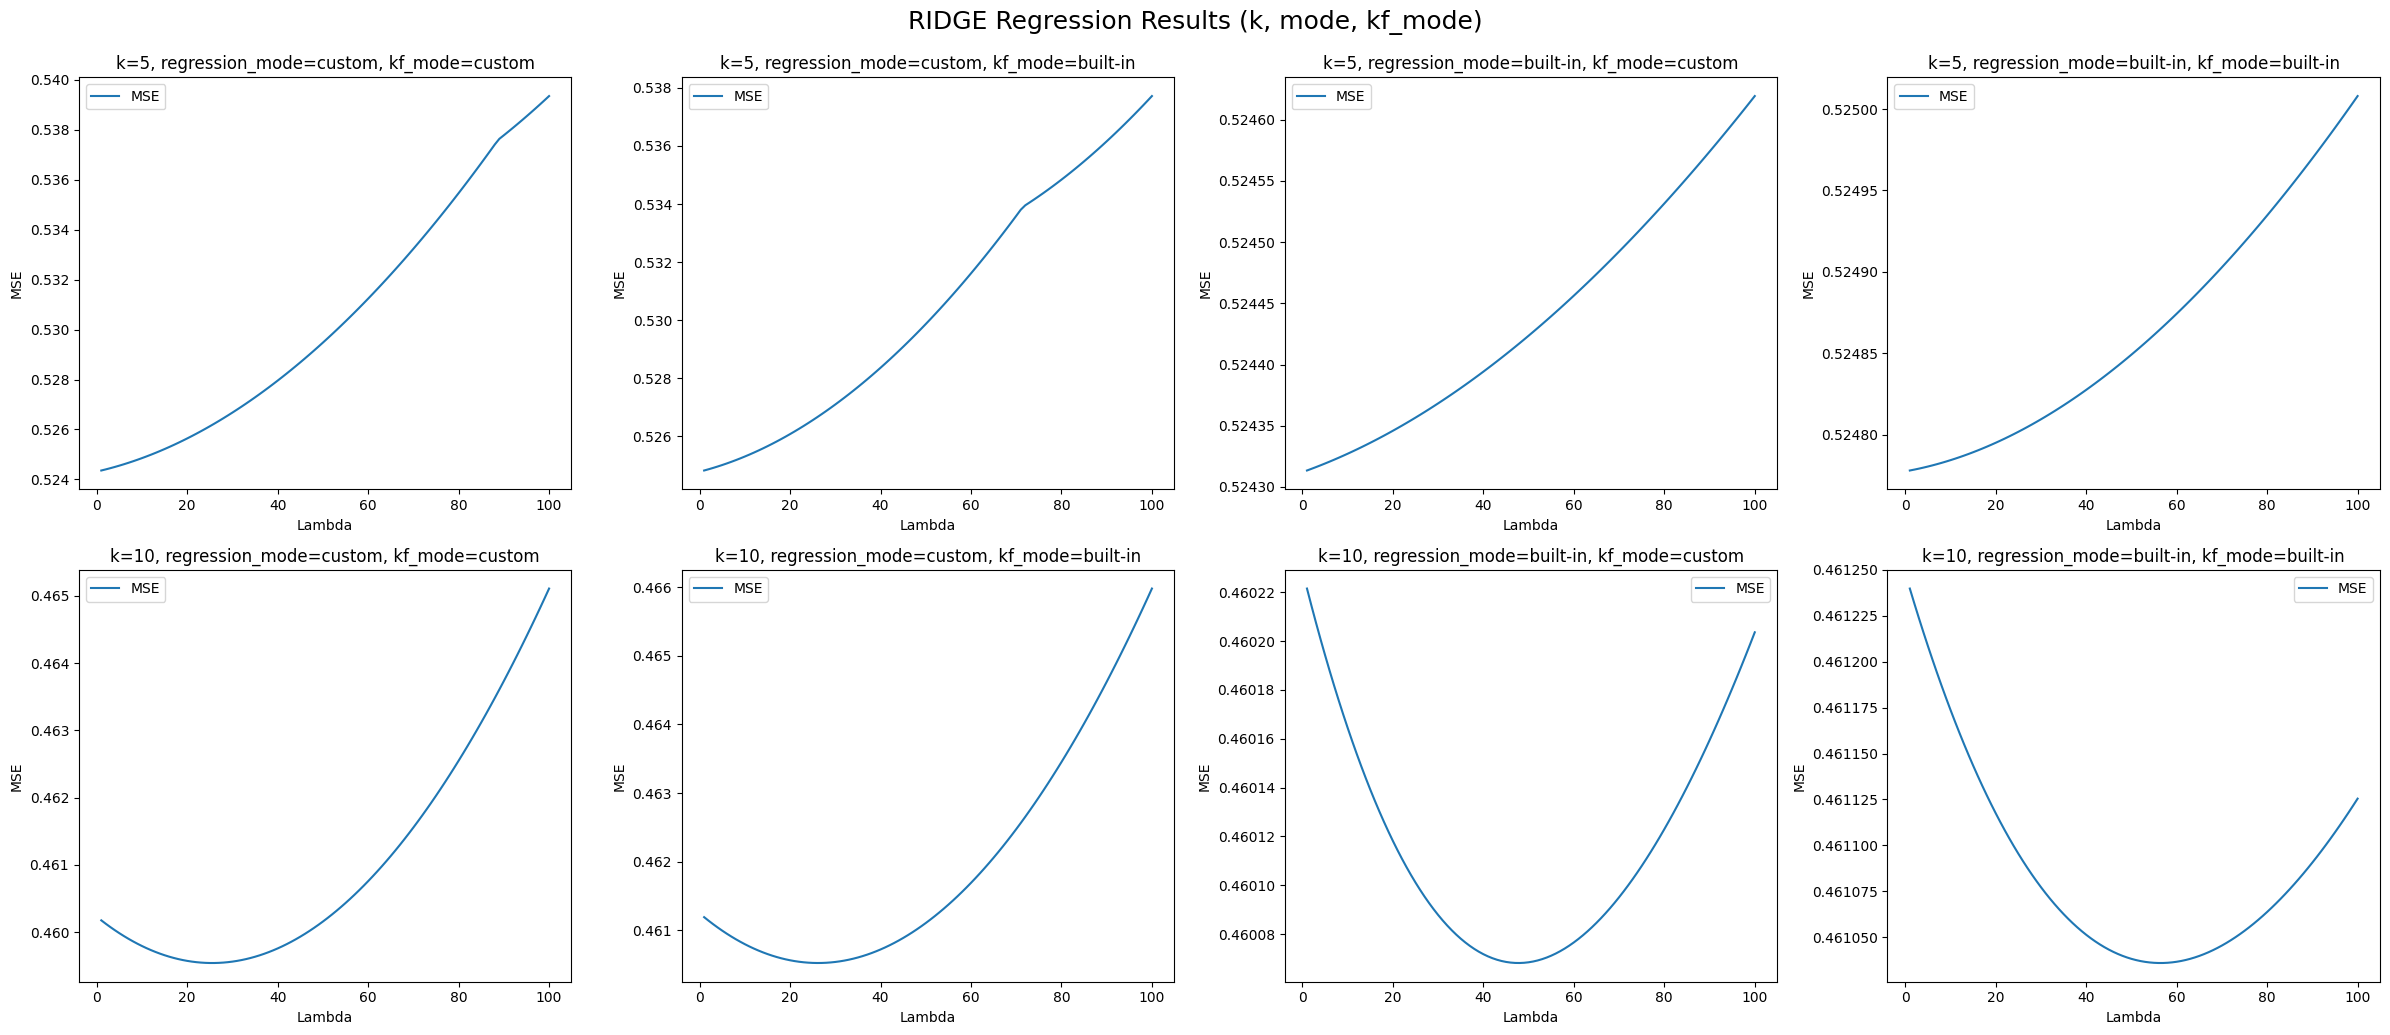

In [154]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_and_plot(X_transformed, y):
    #OLS
    print("\n" + "="*40 + "\nRunning OLS configurations\n" + "="*40)
    for i, (k, mode, kf_mode) in enumerate([(k, mode, kf_mode) for k in [5, 10] for mode in ['custom', 'built-in'] for kf_mode in ['custom', 'built-in']]):
        print(f"\nConfiguration: k={k}, mode={mode}")
        mse, r2 = Kfold_CV(k, X_transformed, y, print_kfold=True, regression='OLS', mode=mode, kf_mode=kf_mode)
        print(f"Results: MSE={mse:.3f}, R2={r2:.3f}\n")
    
    #RIDGE
    print("\n" + "=" * 40 + "\nRunning RIDGE configurations with plots\n" + "=" * 40)
    lambdas = np.arange(1, 101, 1)

    fig, axs = plt.subplots(2, 4, figsize=(24, 10))
    axs = axs.flatten()

    for i, (k, mode, kf_mode) in enumerate([(k, mode, kf_mode) for k in [5, 10] for mode in ['custom', 'built-in'] for kf_mode in ['custom', 'built-in']]):
        mse_lambda = []
        r2_lambda = []
        for alpha in lambdas:
            mse, r2 = Kfold_CV(
                k, X_transformed, y,
                regression='RIDGE', 
                mode=mode, 
                kf_mode=kf_mode, 
                penalty=alpha, 
                lambdas=lambdas
            )
            mse_lambda.append(mse)
            r2_lambda.append(r2)

        best_penalty = lambdas[np.argmin(mse_lambda)]
        best_r2 = r2_lambda[np.argmin(mse_lambda)]
        best_mse = np.min(mse_lambda)

        print(f"\nConfiguration: k={k}, mode={mode}, kf_mode={kf_mode}, regression=RIDGE")
        print(f"Best lambda: {best_penalty}")
        print(f"Best MSE: {best_mse:.3f}, R2: {best_r2:.3f}\n")


        axs[i].plot(lambdas, mse_lambda, label='MSE')
        axs[i].set_title(f'k={k}, regression_mode={mode}, kf_mode={kf_mode}')
        axs[i].set_xlabel('Lambda')
        axs[i].set_ylabel('MSE')
        axs[i].legend()

    plt.tight_layout()
    plt.suptitle("RIDGE Regression Results (k, mode, kf_mode)", fontsize=18, y=1.03)
    plt.show()

evaluate_and_plot(X_transformed, y)


# PLS REGRESSION

In [ ]:
n_splits = [5, 10]

df_pls = pd.DataFrame(columns=['N° splits', 'Fold', 'Best N Components', 'MSE', 'R2'])
df_mse_components = pd.DataFrame(columns=['N° splits', 'Fold', 'N Components', 'MSE', 'R2'])

n_components = np.linspace(1, 11, 11, dtype=int)

for k in n_splits:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for i, (train_index, test_index) in enumerate(kf.split(X_transformed)):
        mse_test_list = []
        r2_test_list = []
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        PLS_X_train = scaler.fit_transform(X_train)
        PLS_X_test = scaler.transform(X_test)
        for n in n_components:
            pls = PLSRegression(n_components=n)
            pls.fit(PLS_X_train, y_train)

            y_pred = pls.predict(PLS_X_test)

            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            mse_test_list.append(mse)
            r2_test_list.append(r2)

            df_mse_components = pd.concat([
                df_mse_components,
                pd.DataFrame({
                    'N° splits': [k],
                    'Fold': [i + 1],
                    'N Components': [n],
                    'MSE': [mse],
                    'R2': [r2]
                })
            ], ignore_index=True)

        best_mse = np.min(mse_test_list)
        best_n = n_components[np.argmin(mse_test_list)]
        best_r2 = r2_test_list[np.argmin(mse_test_list)]
        df_pls = pd.concat([
            df_pls,
            pd.DataFrame({
                'N° splits': [k],
                'Fold': [i + 1],
                'Best N Components': [best_n],
                'MSE': [best_mse],
                'R2': [best_r2]
            })
        ], ignore_index=True)


/tmp/ipykernel_689924/2166706258.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_mse_components = pd.concat([
/tmp/ipykernel_689924/2166706258.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pls = pd.concat([


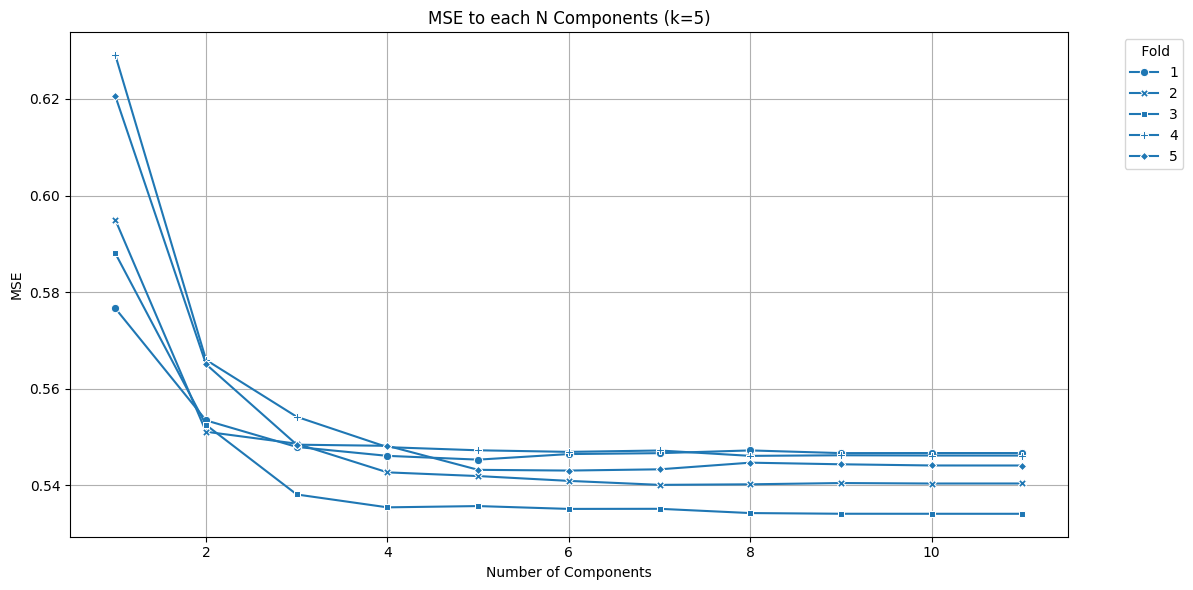

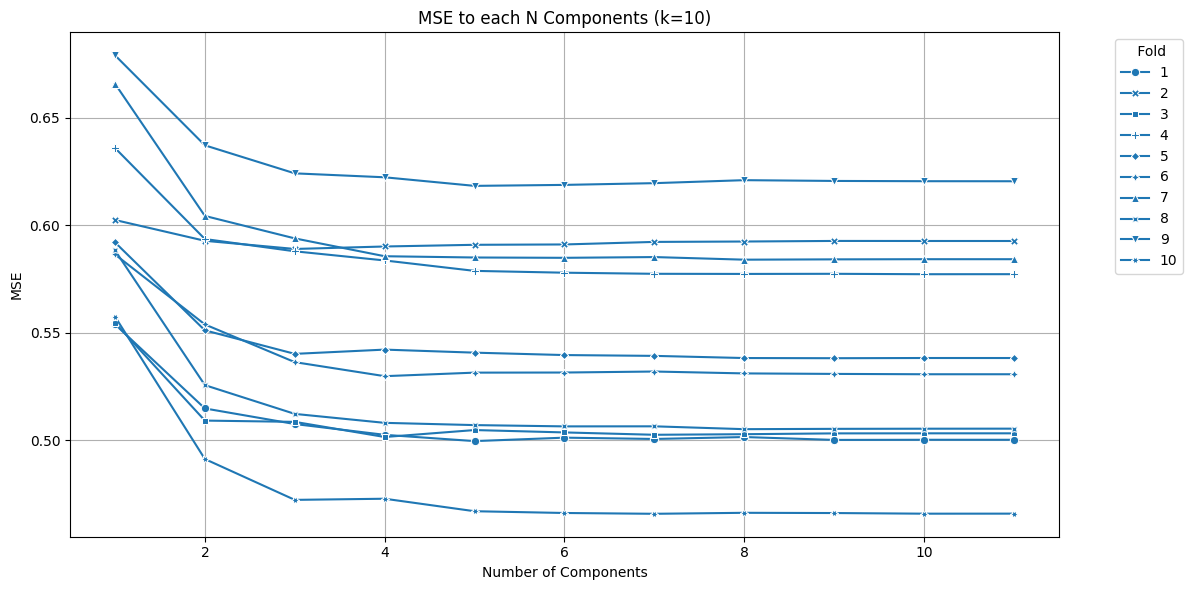

In [237]:
import seaborn as sns
import matplotlib.pyplot as plt

for k in [5,10]:
    plt.figure(figsize=(12, 6))

    sns.lineplot(
        data=df_mse_components.query(f"`N° splits` == {k}"),
        x='N Components',
        y='MSE',
        style='Fold',
        markers=True,
        dashes=False
    )
    plt.title(f'MSE to each N Components (k={k})')
    plt.xlabel('Number of Components')
    plt.ylabel('MSE')
    plt.legend(title=' Fold', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()
    plt.show()


In [239]:
import pandas as pd
from IPython.display import display

def highlight_best_row(df, props):
    best_index = df['MSE'].idxmin()
    return pd.DataFrame(
        [[props if i == best_index else '' for _ in df.columns] for i in df.index],
        index=df.index,
        columns=df.columns
    )

df_k5 = df_pls.query("`N° splits` == 5")
styled_df_k5 = df_k5.style.apply(
    highlight_best_row,
    props='color:white;background-color:gray;font-weight:bold;', 
    axis=None
).set_table_styles(
    [{'selector': 'td', 'props': 'text-align: center;'}]
).format(precision=3)

df_k10 = df_pls.query("`N° splits` == 10")
styled_df_k10 = df_k10.style.apply(
    highlight_best_row,
    props='color:white;background-color:gray;font-weight:bold;', 
    axis=None
).set_table_styles(
    [{'selector': 'td', 'props': 'text-align: center;'}]
).format(precision=3)

display(styled_df_k5)
display(styled_df_k10)


,N° splits,Fold,Best N Components,MSE,R2
0,5,1,5,0.545,0.262
1,5,2,7,0.540,0.291
2,5,3,11,0.534,0.306
3,5,4,8,0.546,0.301
4,5,5,6,0.543,0.285


,N° splits,Fold,Best N Components,MSE,R2
5,10,1,5,0.500,0.304
6,10,2,3,0.589,0.224
7,10,3,4,0.501,0.293
8,10,4,10,0.577,0.290
9,10,5,9,0.538,0.327
10,10,6,4,0.530,0.283
11,10,7,8,0.584,0.296
12,10,8,8,0.505,0.310
13,10,9,5,0.618,0.235
14,10,10,7,0.466,0.344
